# RKA JKN RS 2025

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# SETTING DISPLAY, TAMPILKAN SEMUA BARIS
pd.set_option("display.float_format", '{:,.0f}'.format)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


#LOAD DATA
df_raw = pd.read_excel(
    "/content/RKA JKN 2025 RS TK (2)_COPY.xlsx",
    header=None
)

print(df_raw.head())

              0                1   2   3   4   5   6          7   8       9   \
0  Kode Rekening           URAIAN NaN NaN NaN NaN NaN  Koefisien NaN  Satuan   
1            NaN              NaN NaN NaN NaN NaN NaN        NaN NaN     NaN   
2              5   BELANJA DAERAH NaN NaN NaN NaN NaN        NaN NaN     NaN   
3            5.1  BELANJA OPERASI NaN NaN NaN NaN NaN        NaN NaN     NaN   
4         5.1.01  Belanja Pegawai NaN NaN NaN NaN NaN        NaN NaN     NaN   

    10     11  12   13  14         15   16   17   18   19   20  
0  NaN  Harga NaN  PPN NaN     Jumlah  NaN  NaN  NaN  NaN  NaN  
1  NaN    NaN NaN  NaN NaN        NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN    NaN NaN  NaN NaN  161304000  NaN  NaN  NaN  NaN  NaN  
3  NaN    NaN NaN  NaN NaN  155502327  NaN  NaN  NaN  NaN  NaN  
4  NaN    NaN NaN  NaN NaN  103982400  NaN  NaN  NaN  NaN  NaN  


In [44]:


#PEMETAAN KOLOM (SESUAI STRUKTUR EXCEL)
df = pd.DataFrame({
    "kode": df_raw.iloc[:, 0],
    "uraian": df_raw.iloc[:, 1],
    "koefisien": pd.to_numeric(df_raw.iloc[:, 7], errors="coerce"),
    "satuan": df_raw.iloc[:, 9],
    "harga": pd.to_numeric(df_raw.iloc[:, 11], errors="coerce"),
    "jumlah_col": pd.to_numeric(df_raw.iloc[:, 15], errors="coerce")
})

# Merge cell uraian (ffill)
df["uraian"] = df["uraian"].ffill()

print(df.head(20))


                 kode                                             uraian  \
0       Kode Rekening                                             URAIAN   
1                 NaN                                             URAIAN   
2                   5                                     BELANJA DAERAH   
3                 5.1                                    BELANJA OPERASI   
4              5.1.01                                    Belanja Pegawai   
5           5.1.01.01                     Belanja Gaji dan Tunjangan ASN   
6        5.1.01.01.09                Belanja Iuran Jaminan Kesehatan ASN   
7   5.1.01.01.09.0001                Belanja Iuran Jaminan Kesehatan PNS   
8                 NaN                        [#] Iuran Jaminan Kesehatan   
9                 NaN  Sumber Dana : Pendapatan Dana Kapitasi JKN Pad...   
10                NaN                              [-] Jaminan Kesehatan   
11                NaN                Belanja Iuran Jaminan Kesehatan PNS   
12  5.1.01.0

In [45]:

#FILTER ITEM RIIL (YANG BENAR-BENAR BELANJA)
df_item = df[
    (df["koefisien"].notna()) &
    (df["harga"].notna()) &
    (df["koefisien"] > 0) &
    (df["harga"] > 0)
].copy()

df_item["total"] = df_item["koefisien"] * df_item["harga"]

df_item.head()


,kode,uraian,koefisien,satuan,harga,jumlah_col,total
11,NaN,Belanja Iuran Jaminan Kesehatan PNS,1,Tahun,"3,253,753",0,"3,253,753"
16,NaN,Belanja Iuran Jaminan Kesehatan PPPK,1,Tahun,"1,869,669",0,"1,869,669"
23,NaN,Belanja Jasa Pelayanan Kesehatan Bagi ASN,1,Tahun,"96,782,400","96,782,400","96,782,400"
31,NaN,Jasa Pengelola BMD Pembantu Pengurus Barang\nS...,12,Bulan,"600,000","7,200,000","7,200,000"
39,NaN,Racun rumput,3,Botol,"207,900","623,700","623,700"


In [46]:
# ============================================
# 5. TOTAL AWAL & PAGU
# ============================================
total_awal = df_item["total"].sum()

pagu_max = total_awal
pagu_min = total_awal * 0.80   # efisiensi maksimal 20%


In [47]:

#KATEGORI EFISIENSI RS
def kategori_rs(u):
    u = str(u).lower()
    if any(k in u for k in ["iuran", "jaminan kesehatan", "bpjs"]):
        return "TIDAK BOLEH DIPOTONG"
    elif any(k in u for k in ["jasa pelayanan", "honor", "tambahan penghasilan"]):
        return "TERBATAS"
    else:
        return "PRIORITAS"

df_item["kategori"] = df_item["uraian"].apply(kategori_rs)

ef_range = {
    "TIDAK BOLEH DIPOTONG": (0.0, 0.0),
    "TERBATAS": (0.05, 0.15),
    "PRIORITAS": (0.15, 0.40)
}



In [48]:

#TABEL REKOMENDASI EFISIENSI
np.random.seed(42)

df_item["persen_efisiensi"] = df_item["kategori"].apply(
    lambda k: np.random.uniform(*ef_range[k])
)

df_item["estimasi_hemat_rp"] = df_item["total"] * df_item["persen_efisiensi"]

tabel_rekomendasi = df_item[
    [
        "kode",
        "uraian",
        "koefisien",
        "satuan",
        "harga",
        "total",
        "kategori",
        "persen_efisiensi",
        "estimasi_hemat_rp"
    ]
].sort_values("estimasi_hemat_rp", ascending=False)




In [49]:

# 6. SIMULASI MONTE CARLO
df_mc = df_item[df_item["kategori"] != "TIDAK BOLEH DIPOTONG"]

n_sim = 100_000
hasil_mc = []

for _ in range(n_sim):
    total_hemat = 0
    for _, r in df_mc.iterrows():
        p = np.random.uniform(*ef_range[r["kategori"]])
        total_hemat += r["total"] * p
    hasil_mc.append(total_hemat)

hasil_mc = np.array(hasil_mc)



In [50]:

# 7. TABEL RINGKASAN
target = 20_000_000

ringkasan = pd.DataFrame({
    "Metric": [
        "Total Anggaran Dianalisis",
        "Rata-rata Penghematan",
        "Persentil 95%",
        "Best Case",
        "Worst Case",
        "Probabilitas Capai Target (%)"
    ],
    "Nilai (Rp)": [
        df_item["total"].sum(),
        hasil_mc.mean(),
        np.percentile(hasil_mc, 95),
        hasil_mc.max(),
        hasil_mc.min(),
        np.mean(hasil_mc >= target) * 100
    ]
})


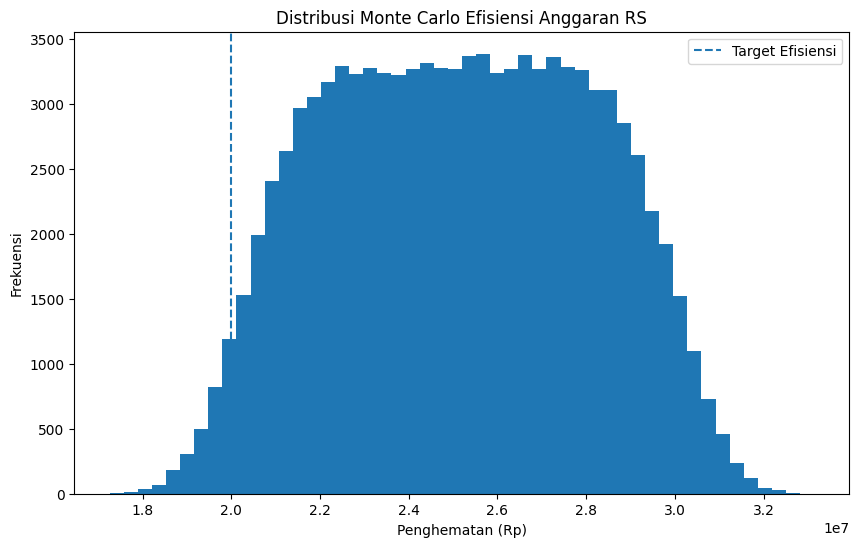

=== TABEL RINGKASAN ===


,Metric,Nilai (Rp)
0,Total Anggaran Dianalisis,"164,744,922"
1,Rata-rata Penghematan,"25,160,771"
2,Persentil 95%,"29,832,949"
3,Best Case,"33,140,905"
4,Worst Case,"17,254,694"
5,Probabilitas Capai Target (%),97



=== SELURUH REKOMENDASI EFISIENSI ===


,kode,uraian,koefisien,satuan,harga,total,kategori,persen_efisiensi,estimasi_hemat_rp
23,NaN,Belanja Jasa Pelayanan Kesehatan Bagi ASN,1,Tahun,"96,782,400","96,782,400",TERBATAS,0,"11,923,533"
31,NaN,Jasa Pengelola BMD Pembantu Pengurus Barang\nS...,12,Bulan,"600,000","7,200,000",PRIORITAS,0,"2,157,585"
97,NaN,Foto copy F4 70 Gr,"6,630",Lembar,700,"4,641,000",PRIORITAS,0,"1,607,150"
63,NaN,Kertas Hvs F4,25,Rim,"131,900","3,297,500",PRIORITAS,0,"1,180,870"
181,NaN,Mesin Press Obat,1,Unit,"4,119,173","4,119,173",PRIORITAS,0,"884,366"
142,NaN,Hand Wash,80,Botol,"34,500","2,760,000",PRIORITAS,0,"717,705"
45,NaN,Bahan Lainnya,35,Pak,"100,000","3,500,000",PRIORITAS,0,"661,495"
150,NaN,Beban Honorarium Tim Pelaksana Kegiatan,12,Bulan,"860,000","10,320,000",TERBATAS,0,"641,943"
81,NaN,Kertas Hvs A4,25,Rim,"126,900","3,172,500",PRIORITAS,0,"586,511"
124,NaN,Tissue 250 sheet 2 ply,60,Per Bungkus,"24,900","1,494,000",PRIORITAS,0,"584,764"


In [51]:

# 8. GRAFIK MONTE CARLO
plt.figure(figsize=(10, 6))
plt.hist(hasil_mc, bins=50)
plt.axvline(target, linestyle="--", label="Target Efisiensi")
plt.title("Distribusi Monte Carlo Efisiensi Anggaran RS")
plt.xlabel("Penghematan (Rp)")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()


# 9. OUTPUT TABEL
print("=== TABEL RINGKASAN ===")
display(ringkasan)

print("\n=== SELURUH REKOMENDASI EFISIENSI ===")
display(tabel_rekomendasi)



=== TABEL PAGU & HASIL EFISIENSI ===
                    Keterangan  Nilai (Rp)
0          Total Anggaran Awal 164,744,922
1                Pagu Maksimum 164,744,922
2                 Pagu Minimum 131,795,938
3  Rata-rata Setelah Efisiensi 139,591,155
4          Efisiensi Rata-rata  25,153,767


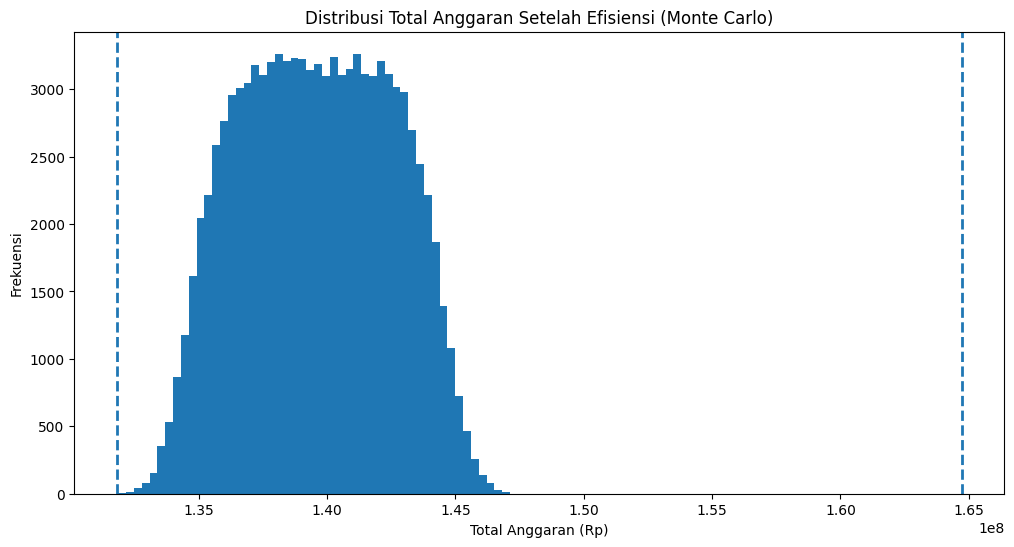

In [54]:

# 7. MONTE CARLO DENGAN BATAS PAGU
n_sim = 100_000
hasil_valid = []

for _ in range(n_sim):
    total_akhir = 0
    for _, r in df_item.iterrows():
        low, high = ef_range[r["kategori"]]
        ef = np.random.uniform(low, high)
        total_akhir += r["total"] * (1 - ef)
    if total_akhir >= pagu_min:
        hasil_valid.append(total_akhir)

hasil_valid = np.array(hasil_valid)




# 8. TABEL RINGKASAN
tabel_pagu = pd.DataFrame({
    "Keterangan": [
        "Total Anggaran Awal",
        "Pagu Maksimum",
        "Pagu Minimum",
        "Rata-rata Setelah Efisiensi",
        "Efisiensi Rata-rata"
    ],
    "Nilai (Rp)": [
        total_awal,
        pagu_max,
        pagu_min,
        hasil_valid.mean(),
        total_awal - hasil_valid.mean()
    ]
})
print("\n=== TABEL PAGU & HASIL EFISIENSI ===")
print(tabel_pagu)




# 9. VISUALISASI
plt.figure(figsize=(12,6))
plt.hist(hasil_valid, bins=50)
plt.axvline(pagu_min, linestyle="--", linewidth=2)
plt.axvline(total_awal, linestyle="--", linewidth=2)
plt.title("Distribusi Total Anggaran Setelah Efisiensi (Monte Carlo)")
plt.xlabel("Total Anggaran (Rp)")
plt.ylabel("Frekuensi")
plt.show()
